![JohnSnowLabs](https://nlp.johnsnowlabs.com/assets/images/logo.png)

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/JohnSnowLabs/spark-nlp-workshop/blob/master/tutorials/Certification_Trainings/Healthcare/3.3.MedDRA_Models.ipynb)

# MedDRA Models


**What is MedDRA(Medical Dictionary for Regulatory Activities)?**

MedDRA is a clinically-validated international medical terminology used by regulatory authorities and the regulated biopharmaceutical industry. The terminology is used through the entire regulatory process, from pre-marketing to post-marketing, and for data entry, retrieval, evaluation, and presentation.

MedDRA is structured hierarchically;

* System Organ Classes (SOCs): SOCs are general categories that represent different body systems or medical areas. Some examples of SOCs are: Heart problems (Cardiac disorders), Nervous system issues (Nervous system disorders) In total, there are 27 SOCs.

* High-Level Group Terms (HLGTs): Within each SOC are HLGTs. HLGTs further specify the categories within a SOC. They group similar medical conditions or diseases. For example, within the SOC “Nervous system disorders,” there could be an HLGT named “Headache and migraine disorders.”

* High-Level Terms (HLTs): HLTs further refine high-level group terms (HLGTs) by providing more specific descriptions of medical conditions. They still represent broader groups of related terms but with greater detail. For example, the HLT “Migraine disorders” falls under the HLGT “Headache and migraine disorders.”

* Preferred Terms (PTs): PTs are the most specific level in the MedDRA hierarchy. They represent individual medical concepts or terms. PTs provide highly detailed descriptions of specific medical events or conditions. Within the HLT “Migraine disorders,” for instance, a PT could be “Migraine with aura,” which indicates the specific type of migraine.

* Lowest Level Terms (LLTs): LLTs are equivalent to Preferred Terms (PTs) and represent the most specific and detailed descriptions of medical concepts.



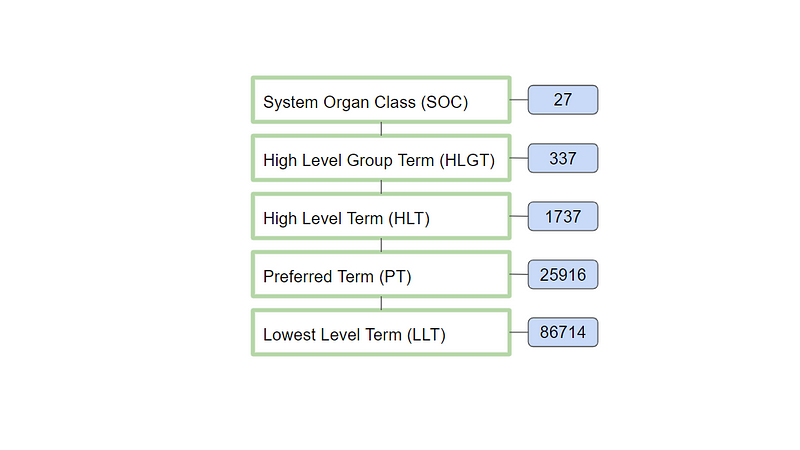

## Healthcare NLP for Data Scientists Course

If you are not familiar with the components in this notebook, you can check [Healthcare NLP for Data Scientists Udemy Course](https://www.udemy.com/course/healthcare-nlp-for-data-scientists/) and the [MOOC Notebooks](https://github.com/JohnSnowLabs/spark-nlp-workshop/tree/master/Spark_NLP_Udemy_MOOC/Healthcare_NLP) for each components.

## Setup

In [ ]:
import json
import os

from google.colab import files

license_keys = files.upload()

with open(list(license_keys.keys())[0]) as f:
    license_keys = json.load(f)

locals().update(license_keys)

os.environ.update(license_keys)

In [ ]:
# Installing pyspark and spark-nlp
! pip install --upgrade -q pyspark==3.5.1 spark-nlp==$PUBLIC_VERSION

# Installing Spark NLP Healthcare
! pip install --upgrade -q spark-nlp-jsl==$JSL_VERSION  --extra-index-url https://pypi.johnsnowlabs.com/$SECRET

# Installing Spark NLP Display Library for visualization
! pip install -q spark-nlp-display

In [3]:
import sparknlp
import sparknlp_jsl

from sparknlp.base import *
from sparknlp.annotator import *
from sparknlp_jsl.annotator import *
from sparknlp_jsl.pretrained import InternalResourceDownloader

from pyspark.sql import functions as F
from pyspark.sql.types import StringType, IntegerType

from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.ml import Pipeline,PipelineModel

import pandas as pd
pd.set_option('display.max_colwidth', 200)

import warnings
warnings.filterwarnings('ignore')

params = {"spark.driver.memory":"16G",
          "spark.kryoserializer.buffer.max":"2000M",
          "spark.driver.maxResultSize":"2000M"}

print("Spark NLP Version :", sparknlp.version())
print("Spark NLP_JSL Version :", sparknlp_jsl.version())

spark = sparknlp_jsl.start(license_keys['SECRET'],params=params)

spark

Spark NLP Version : 6.1.3
Spark NLP_JSL Version : 6.1.1


## MedDRA Models/ Mappers
|index|model|
|-----:|:-----|
| 1| [sbiobertresolve_meddra_preferred_term](https://nlp.johnsnowlabs.com/2024/03/24/sbiobertresolve_meddra_preferred_term_en.html)
| 2| [sbiobertresolve_meddra_lowest_level_term](https://nlp.johnsnowlabs.com/2024/03/24/sbiobertresolve_meddra_lowest_level_term_en.html)
| 3| [meddra_pt_hlt_mapper](https://nlp.johnsnowlabs.com/2024/03/28/meddra_pt_hlt_mapper_en.html)  
| 4| [meddra_hlt_pt_mapper](https://nlp.johnsnowlabs.com/2024/03/28/meddra_hlt_pt_mapper_en.html)
| 5| [icd10_meddra_llt_mapper](https://nlp.johnsnowlabs.com/2024/03/14/icd10_meddra_llt_mapper_en.html)
| 6| [meddra_llt_icd10_mapper](https://nlp.johnsnowlabs.com/2024/03/14/meddra_llt_icd10_mapper_en.html)
| 7| [meddra_llt_pt_mapper](https://nlp.johnsnowlabs.com/2024/03/18/meddra_llt_pt_mapper_en.html)
| 8| [meddra_pt_llt_mapper](https://nlp.johnsnowlabs.com/2024/03/18/meddra_pt_llt_mapper_en.html)
| 9| [meddra_pt_icd10_mapper](https://nlp.johnsnowlabs.com/2024/03/15/meddra_pt_icd10_mapper_en.html)
| 10| [icd10_meddra_pt_mapper](https://nlp.johnsnowlabs.com/2024/03/15/icd10_meddra_pt_mapper_en.html)
| 11| [meddra_llt_snomed_mapper](https://nlp.johnsnowlabs.com/2024/05/14/meddra_llt_snomed_mapper_en.html)  
| 12| [snomed_meddra_llt_mapper](https://nlp.johnsnowlabs.com/2024/05/24/snomed_meddra_llt_mapper_en.html)  




**Please note that you CAN NOT download this model using `.pretrained` method. To utilize this model, you need to have a valid MedDRA license. If you possess one and wish to use this model, kindly contact us at support@johnsnowlabs.com**

# Resolver Models

In this section of the notebook, we will explain the steps involved in building our text processing pipeline aimed at coding medical text with MedDRA and subsequently mapping these codes to ICD-10 codes. The pipeline operates as follows after `WordEmbeddings` step:


1.  **Named Entity Extraction:** Pretrained `ner_jsl` model is utilized to identify and extract medical entities that fall within the scope of the MedDRA coding system.

2.   **Entity Embedding:** After extracting the relevant entities, their textual representations are transformed into numerical data, or embeddings, using the sbio_bert model. Embeddings capture the semantic essence of the entities, which aids in the next step of determining the appropriate MedDRA codes.

3.  **MedDRA Resolver Model:** These embeddings are input into a pretrained MedDRA resolver model. This model assesses the semantic similarity between the embeddings of the extracted entities and the descriptions within the medical terminology database. The goal is to assign the most semantically similar MedDRA code to each entity based on these comparisons.

4. **Code Mapping:** After obtaining MedDRA codes, the final step involves mapping these codes to the ICD-10 (International Classification of Diseases, Tenth Revision) codes.


Create a spark dataframe using sample clinical notes.

In [ ]:
text_list = [
    """This is an 82-year-old male with a history of prior tobacco use, benign hypertension, chronic renal insufficiency, chronic bronchitis, gastritis, and ischemic attack. He initially presented to Braintree with ST elevation and was transferred to St. Margaret’s Center. He underwent cardiac catheterization because of the left main coronary artery stenosis, which was complicated by hypotension and bradycardia. We describe the side effects of 5-FU in a colon cancer patient who suffered mucositis and dermatitis.""",
    """We describe the side effects of 5-FU in a colon cancer patient who suffered mucositis, dermatitis, prolonged myelosuppression, and neurologic toxicity that required admission to the intensive care unit. Anterior lumbosacral radiculopathy after intrathecal methotrexate treatment and acute erythroid leukemia after cyclophosphamide therapy for plasma cell myeloma: report of two cases.""",
    """I've been using Arthrotec 50 on and off for over 10 years, only taking it when necessary. However, I have begun experiencing dizziness and tinnitus due to this medication. Due to worsening arthritis, I started taking it twice a day at age 50, which led to gastritis. I had to take it daily for the next month to assess its effects, and that's been the extent of my usage.""",
    ]

df = spark.createDataFrame(pd.DataFrame({"text": text_list}))

## sbiobertresolve_meddra_preferred_term

**Let's build the pipeline.**

In [ ]:
documentAssembler = DocumentAssembler()\
    .setInputCol("text")\
    .setOutputCol("document")

sentenceDetector = SentenceDetectorDLModel.pretrained("sentence_detector_dl_healthcare","en","clinical/models")\
    .setInputCols(["document"])\
    .setOutputCol("sentence")

tokenizer = Tokenizer()\
    .setInputCols(["sentence"])\
    .setOutputCol("token")

word_embeddings = WordEmbeddingsModel.pretrained("embeddings_clinical","en", "clinical/models")\
    .setInputCols(["sentence", "token"])\
    .setOutputCol("embeddings")

ner_jsl = MedicalNerModel.pretrained("ner_jsl", "en", "clinical/models")\
    .setInputCols(["sentence", "token", "embeddings"])\
    .setOutputCol("ner_jsl")

ner_jsl_converter = NerConverter()\
    .setInputCols(["sentence", "token", "ner_jsl"])\
    .setOutputCol("ner_jsl_chunk")\
    .setWhiteList(["Procedure","Kidney_Disease","Cerebrovascular_Disease","Heart_Disease",
                    "Disease_Syndrome_Disorder", "Symptom", "VS_Finding",
                    "EKG_Findings", "Communicable_Disease",
                    "Internal_organ_or_component","External_body_part_or_region",
                    "Triglycerides","Alcohol","Smoking","Pregnancy","Hypertension","Obesity",
                    "Injury_or_Poisoning","Test","Hyperlipidemia","Oncological",
                    "Psychological_Condition","LDL","Diabetes"])


ner_ade_clinical = MedicalNerModel.pretrained("ner_ade_clinical", "en", "clinical/models")\
    .setInputCols(["sentence", "token", "embeddings"])\
    .setOutputCol("ade_clinica_ner")

ner_ade_clinical_converter = NerConverterInternal()\
    .setInputCols(["sentence", "token", "ade_clinica_ner"])\
    .setOutputCol("ner_ade_clinical_chunk")\
    .setWhiteList(["ADE"])

chunk_merger = ChunkMergeApproach()\
    .setInputCols('ner_ade_clinical_chunk',"ner_jsl_chunk")\
    .setOutputCol('merged_ner_chunk')

chunk2doc = Chunk2Doc() \
    .setInputCols("merged_ner_chunk") \
    .setOutputCol("ner_chunk_doc")

sbert_embedder = BertSentenceEmbeddings.pretrained("sbiobert_base_cased_mli","en","clinical/models")\
    .setInputCols(["ner_chunk_doc"])\
    .setOutputCol("sbert_embeddings")\
    .setCaseSensitive(False)

meddra_resolver = SentenceEntityResolverModel.load("sbiobertresolve_meddra_preferred_term_5.3.0") \
    .setInputCols(["sbert_embeddings"]) \
    .setOutputCol("meddra_pt_code")\
    .setDistanceFunction("EUCLIDEAN")

resolver2chunk = Resolution2Chunk()\
    .setInputCols(["meddra_pt_code"])\
    .setOutputCol("meddra2chunk")

icd_mapperModel = ChunkMapperModel.load('meddra_pt_icd10_mapper_5.3.0')\
    .setInputCols(["meddra2chunk"])\
    .setOutputCol("icd10_mappings")\
    .setRels(["icd10_code"])

nlpPipeline= Pipeline(stages=[
          documentAssembler,
          sentenceDetector,
          tokenizer,
          word_embeddings,
          ner_jsl,
          ner_jsl_converter,
          ner_ade_clinical,
          ner_ade_clinical_converter,
          chunk_merger,
          chunk2doc,
          sbert_embedder,
          meddra_resolver,
          resolver2chunk,
          icd_mapperModel
])

empty_df = spark.createDataFrame([['']]).toDF("text")

resolver_pipeline = nlpPipeline.fit(empty_df)

result = resolver_pipeline.transform(df)

In [ ]:
result.select(F.explode(F.arrays_zip(result.merged_ner_chunk.result,
                                     result.merged_ner_chunk.begin,
                                     result.merged_ner_chunk.end,
                                     result.merged_ner_chunk.metadata,
                                     result.meddra_pt_code.result,
                                     result.meddra_pt_code.metadata,
                                     result.icd10_mappings.result,)).alias("cols"))\
      .select(F.expr("cols['0']").alias("ner_chunk"),
              F.expr("cols['1']").alias("begin"),
              F.expr("cols['2']").alias("end"),
              F.expr("cols['3'].entity").alias("entity"),
              F.expr("cols['4']").alias("meddra_pt_code"),
              F.expr("cols['5']['resolved_text']").alias("resolved_text"),
              F.expr("cols['5']['all_k_results']").alias("all_k_results"),
              F.expr("cols['5']['all_k_resolutions']").alias("all_k_resolutions"),
              F.expr("cols['6']").alias("icd10_mappings")).show(truncate=40)

**Display the PT code using the Spark NLP Display library.**

In [ ]:
from sparknlp_display import EntityResolverVisualizer

er_vis = EntityResolverVisualizer()

light_model = LightPipeline(resolver_pipeline)
lresult = light_model.fullAnnotate(text_list[0])

er_vis.display(lresult[0],
               label_col='merged_ner_chunk',
               resolution_col = 'meddra_pt_code',
               document_col='document'
               )

## sbiobertresolve_meddra_lowest_level_term

**Let's build the pipeline.**

In [ ]:
documentAssembler = DocumentAssembler()\
    .setInputCol("text")\
    .setOutputCol("document")

sentenceDetector = SentenceDetectorDLModel.pretrained("sentence_detector_dl_healthcare","en","clinical/models")\
    .setInputCols(["document"])\
    .setOutputCol("sentence")

tokenizer = Tokenizer()\
    .setInputCols(["sentence"])\
    .setOutputCol("token")

word_embeddings = WordEmbeddingsModel.pretrained("embeddings_clinical","en", "clinical/models")\
    .setInputCols(["sentence", "token"])\
    .setOutputCol("embeddings")

ner_jsl = MedicalNerModel.pretrained("ner_jsl", "en", "clinical/models")\
    .setInputCols(["sentence", "token", "embeddings"])\
    .setOutputCol("ner_jsl")

ner_jsl_converter = NerConverter()\
    .setInputCols(["sentence", "token", "ner_jsl"])\
    .setOutputCol("ner_jsl_chunk")\
    .setWhiteList(["Procedure","Kidney_Disease","Cerebrovascular_Disease","Heart_Disease",
                    "Disease_Syndrome_Disorder", "Symptom", "VS_Finding",
                    "EKG_Findings", "Communicable_Disease",
                    "Internal_organ_or_component","External_body_part_or_region",
                    "Triglycerides","Alcohol","Smoking","Pregnancy","Hypertension","Obesity",
                    "Injury_or_Poisoning","Test","Hyperlipidemia","Oncological",
                    "Psychological_Condition","LDL","Diabetes"])

ner_ade_clinical = MedicalNerModel.pretrained("ner_ade_clinical", "en", "clinical/models")\
    .setInputCols(["sentence", "token", "embeddings"])\
    .setOutputCol("ade_clinica_ner")

ner_ade_clinical_converter = NerConverterInternal()\
    .setInputCols(["sentence", "token", "ade_clinica_ner"])\
    .setOutputCol("ner_ade_clinical_chunk")\
    .setWhiteList(["ADE"])

chunk_merger = ChunkMergeApproach()\
    .setInputCols('ner_ade_clinical_chunk',"ner_jsl_chunk")\
    .setOutputCol('merged_ner_chunk')

chunk2doc = Chunk2Doc() \
    .setInputCols("merged_ner_chunk") \
    .setOutputCol("ner_chunk_doc")

sbert_embedder = BertSentenceEmbeddings.pretrained("sbiobert_base_cased_mli","en","clinical/models")\
    .setInputCols(["ner_chunk_doc"])\
    .setOutputCol("sbert_embeddings")\
    .setCaseSensitive(False)

meddra_resolver = SentenceEntityResolverModel.load("sbiobertresolve_meddra_lowest_level_term_5.3.0") \
    .setInputCols(["sbert_embeddings"]) \
    .setOutputCol("meddra_llt_code")\
    .setDistanceFunction("EUCLIDEAN")

resolver2chunk = Resolution2Chunk()\
    .setInputCols(["meddra_llt_code"])\
    .setOutputCol("meddra2chunk")

icd_mapperModel = ChunkMapperModel.load('meddra_llt_icd10_mapper_5.3.0')\
    .setInputCols(["meddra2chunk"])\
    .setOutputCol("icd10_mappings")\
    .setRels(["icd10_code"])

snomed_mapperModel = ChunkMapperModel.load('meddra_llt_snomed_mapper_5.3.2')\
    .setInputCols(["meddra2chunk"])\
    .setOutputCol("snomed_mappings")\
    .setRels(["snomed_code"])


nlpPipeline= Pipeline(stages=[
        documentAssembler,
        sentenceDetector,
        tokenizer,
        word_embeddings,
        ner_jsl,
        ner_jsl_converter,
        ner_ade_clinical,
        ner_ade_clinical_converter,
        chunk_merger,
        chunk2doc,
        sbert_embedder,
        meddra_resolver,
        resolver2chunk,
        icd_mapperModel,
        snomed_mapperModel
])

text= """This is an 82-year-old male with a history of prior tobacco use, benign hypertension, chronic renal insufficiency, chronic bronchitis, gastritis, and ischemic attack. He initially presented to Braintree with ST elevation and was transferred to St. Margaret’s Center. He underwent cardiac catheterization because of the left main coronary artery stenosis, which was complicated by hypotension and bradycardia. We describe the side effects of 5-FU in a colon cancer patient who suffered mucositis and dermatitis."""

df= spark.createDataFrame([[text]]).toDF("text")

resolver_pipeline= nlpPipeline.fit(df)
result = resolver_pipeline.transform(df)

In [ ]:
result.select(F.explode(F.arrays_zip(result.merged_ner_chunk.result,
                                     result.merged_ner_chunk.begin,
                                     result.merged_ner_chunk.end,
                                     result.merged_ner_chunk.metadata,
                                     result.meddra_llt_code.result,
                                     result.meddra_llt_code.metadata,
                                     result.icd10_mappings.result,
                                     result.snomed_mappings.result,)).alias("cols"))\
      .select(F.expr("cols['0']").alias("ner_chunk"),
              F.expr("cols['1']").alias("begin"),
              F.expr("cols['2']").alias("end"),
              F.expr("cols['3'].entity").alias("entity"),
              F.expr("cols['4']").alias("meddra_llt_code"),
              F.expr("cols['5']['resolved_text']").alias("resolution"),
              F.expr("cols['5']['all_k_results']").alias("all_k_results"),
              F.expr("cols['5']['all_k_resolutions']").alias("all_k_resolutions"),
              F.expr("cols['6']").alias("icd10_mappings"),
              F.expr("cols['7']").alias("snomed_mappings")).show(truncate=40)

**Display the LLT code using the Spark NLP Display library.**

In [ ]:
from sparknlp_display import EntityResolverVisualizer

er_vis = EntityResolverVisualizer()

light_model = LightPipeline(resolver_pipeline)
lresult = light_model.fullAnnotate(text_list[0])

er_vis.display(lresult[0],
               label_col='merged_ner_chunk',
               resolution_col = 'meddra_llt_code',
               document_col='document'
               )

# Mapper Models

## meddra_llt_snomed_mapper

In [ ]:
documentAssembler = DocumentAssembler()\
    .setInputCol("text")\
    .setOutputCol("ner_chunk")

sbert_embedder = BertSentenceEmbeddings.pretrained("sbiobert_base_cased_mli", "en", "clinical/models")\
    .setInputCols(["ner_chunk"])\
    .setOutputCol("sbert_embeddings")\
    .setCaseSensitive(False)

meddra_resolver = SentenceEntityResolverModel.load("sbiobertresolve_meddra_lowest_level_term_5.3.0")\
    .setInputCols(["sbert_embeddings"]) \
    .setOutputCol("meddra_llt_code")\
    .setDistanceFunction("EUCLIDEAN")

resolver2chunk = Resolution2Chunk()\
    .setInputCols(["meddra_llt_code"])\
    .setOutputCol("meddra_llt_code2chunk")

chunkMapper = ChunkMapperModel.load('meddra_llt_snomed_mapper_5.3.2')\
    .setInputCols(["meddra_llt_code2chunk"])\
    .setOutputCol("mappings")\
    .setRels(["snomed_code"])


pipeline = Pipeline(stages = [
    documentAssembler,
    sbert_embedder,
    meddra_resolver,
    resolver2chunk,
    chunkMapper])

data = spark.createDataFrame([["Chronic renal insufficiency"], ["Gastritis"], ["Transient ischemic attack"]]).toDF("text")

result = pipeline.fit(data).transform(data)

In [ ]:
result.select(F.explode(F.arrays_zip(result.ner_chunk.result,
                                  result.meddra_llt_code.result,
                                  result.mappings.result),).alias("cols"))\
    .select(F.expr("cols['0']").alias("chunk"),
            F.expr("cols['1']").alias("meddra_code"),
            F.expr("cols['2']").alias("snomed_code"),
           ).show(truncate=60)

## snomed_meddra_llt_mapper

In [ ]:
documentAssembler = DocumentAssembler()\
    .setInputCol("text")\
    .setOutputCol("ner_chunk")

sbert_embedder = BertSentenceEmbeddings.pretrained("sbiobert_base_cased_mli", "en", "clinical/models")\
    .setInputCols(["ner_chunk"])\
    .setOutputCol("sbert_embeddings")\
    .setCaseSensitive(False)

snomed_resolver = SentenceEntityResolverModel.pretrained("sbiobertresolve_snomed_conditions", "en", "clinical/models")\
    .setInputCols(["sbert_embeddings"]) \
    .setOutputCol("snomed_code")\
    .setDistanceFunction("EUCLIDEAN")

resolver2chunk = Resolution2Chunk()\
    .setInputCols(["snomed_code"])\
    .setOutputCol("snomed2chunk")

chunkMapper = ChunkMapperModel.load('snomed_meddra_llt_mapper_5.3.2')\
    .setInputCols(["snomed2chunk"])\
    .setOutputCol("mappings")\
    .setRels(["meddra_code"])

pipeline = Pipeline(stages = [
    documentAssembler,
    sbert_embedder,
    snomed_resolver,
    resolver2chunk,
    chunkMapper])


data = spark.createDataFrame([["Fungal infection of lung"], ["Abdominal pain"], ["wheezing"]]).toDF("text")

result = pipeline.fit(data).transform(data)

In [ ]:
result.select(F.explode(F.arrays_zip(result.ner_chunk.result,
                                     result.snomed_code.result,
                                     result.mappings.result,
                                     result.mappings.metadata),).alias("cols"))\
    .select(F.expr("cols['0']").alias("chunk"),
            F.expr("cols['1']").alias("snomed_code"),
            F.expr("cols['2']").alias("meddra_code"),
            F.expr("cols['3']['all_k_resolutions']").alias("all_k_resolutions")
           ).show(truncate=60)

## meddra_pt_hlt_mapper

In [ ]:
document_assembler = DocumentAssembler()\
    .setInputCol('text')\
    .setOutputCol('doc')

chunk_assembler = Doc2Chunk()\
    .setInputCols(['doc'])\
    .setOutputCol('pt_code')

mapperModel = ChunkMapperModel.load('meddra_pt_hlt_mapper_5.3.1')\
    .setInputCols(["pt_code"])\
    .setOutputCol("hlt_mapping")\
    .setRels(["hlt_code"])

pipeline = Pipeline(stages=[
    document_assembler,
    chunk_assembler,
    mapperModel
])


text=["""10014468""", """10017677""", """10014490"""]
data = spark.createDataFrame(text, StringType()).toDF("text")

mapper_model = pipeline.fit(data)
result = mapper_model.transform(data)

In [ ]:
result=result.select(F.explode(F.arrays_zip(result.pt_code.result,
                                            result.hlt_mapping.result,
                                            result.hlt_mapping.metadata)).alias("cols"))\
              .select(F.expr("cols['0']").alias("pt_code"),
                      F.expr("cols['1']").alias("hlt_mapping"),
                      F.expr("cols['2']['all_k_resolutions']").alias("all_k_resolutions")
                    ).toPandas()
result

## meddra_hlt_pt_mapper

In [ ]:
document_assembler = DocumentAssembler()\
    .setInputCol('text')\
    .setOutputCol('doc')

chunk_assembler = Doc2Chunk()\
    .setInputCols(['doc'])\
    .setOutputCol('hlt_code')

mapperModel = ChunkMapperModel.load('meddra_hlt_pt_mapper_5.3.1')\
    .setInputCols(["hlt_code"])\
    .setOutputCol("pt_mappings")\
    .setRels(["pt_code"])


mapper_pipeline = Pipeline(stages=[
    document_assembler,
    chunk_assembler,
    mapperModel
])


text=["""10000135""", """10017329""", """10000332"""]
data = spark.createDataFrame(text, StringType()).toDF("text")

mapper_model = mapper_pipeline.fit(data)
result = mapper_model.transform(data)

In [ ]:
result=result.select(F.explode(F.arrays_zip(result.hlt_code.result,
                                            result.pt_mappings.result,
                                            result.pt_mappings.metadata)).alias("cols"))\
              .select(F.expr("cols['0']").alias("hlt_code"),
                      F.expr("cols['1']").alias("pt_mapping"),
                      F.expr("cols['2']['all_k_resolutions']").alias("all_k_resolutions")
                    ).toPandas()
result

## icd10_meddra_llt_mapper

In [ ]:
documentAssembler = DocumentAssembler()\
    .setInputCol("text")\
    .setOutputCol("ner_chunk")

sbert_embedder = BertSentenceEmbeddings.pretrained("sbiobert_base_cased_mli", "en", "clinical/models")\
    .setInputCols(["ner_chunk"])\
    .setOutputCol("sbert_embeddings")\
    .setCaseSensitive(False)

icd10_resolver = SentenceEntityResolverModel.pretrained("sbiobertresolve_icd10cm_augmented", "en", "clinical/models")\
    .setInputCols(["sbert_embeddings"]) \
    .setOutputCol("icd10_code")\
    .setDistanceFunction("EUCLIDEAN")

resolver2chunk = Resolution2Chunk()\
    .setInputCols(["icd10_code"])\
    .setOutputCol("icd102chunk")

chunkerMapper = ChunkMapperModel.load("icd10_meddra_llt_mapper_5.3.0")\
    .setInputCols(["icd102chunk"])\
    .setOutputCol("mappings")

pipeline = Pipeline(stages = [
    documentAssembler,
    sbert_embedder,
    icd10_resolver,
    resolver2chunk,
    chunkerMapper])

text=[
    """Type 2 diabetes mellitus""",
    """Typhoid fever""",
    """Malignant neoplasm of oesophagus"""
]

data = spark.createDataFrame(text, StringType()).toDF("text")

result = pipeline.fit(data).transform(data)

In [ ]:
result=result.select(F.explode(F.arrays_zip(result.ner_chunk.result,
                                            result.icd10_code.result,
                                            result.mappings.result)).alias("cols"))\
              .select(F.expr("cols['0']").alias("chunk"),
                      F.expr("cols['1']").alias("icd10_code"),
                      F.expr("cols['2']").alias("meddra_code")
                    ).toPandas()
result

## meddra_llt_pt_mapper

In [ ]:
document_assembler = DocumentAssembler()\
    .setInputCol('text')\
    .setOutputCol('doc')

chunk_assembler = Doc2Chunk()\
    .setInputCols(['doc'])\
    .setOutputCol('chunk')

mapperModel = ChunkMapperModel.load('meddra_llt_pt_mapper_5.3.0')\
    .setInputCols(["chunk"])\
    .setOutputCol("mappings")\
    .setRels(["pt_code"])

pipeline = Pipeline(stages=[
    document_assembler,
    chunk_assembler,
    mapperModel
])

text=["""10002442""", """10000007""", """10003696"""]
data = spark.createDataFrame(text, StringType()).toDF("text")

result = pipeline.fit(data).transform(data)

In [ ]:
result=result.select(F.explode(F.arrays_zip(result.chunk.result,
                                            result.mappings.result,
                                            result.mappings.metadata)).alias("cols"))\
              .select(F.expr("cols['0']").alias("llt_code"),
                      F.expr("cols['1']").alias("pt_code"),
                      F.expr("cols['2']['all_k_resolutions']").alias("all_k_resolutions")
                    ).toPandas()
result

## meddra_pt_llt_mapper

In [ ]:
document_assembler = DocumentAssembler()\
    .setInputCol('text')\
    .setOutputCol('doc')

chunk_assembler = Doc2Chunk()\
    .setInputCols(['doc'])\
    .setOutputCol('ner_chunk')

mapperModel = ChunkMapperModel.load('meddra_pt_llt_mapper_5.3.0')\
    .setInputCols(["ner_chunk"])\
    .setOutputCol("mappings")\
    .setRels(["llt_code"])

mapper_pipeline = Pipeline(stages=[
    document_assembler,
    chunk_assembler,
    mapperModel
])

text=["""10008684""", """10014472""", """10019785"""]
data = spark.createDataFrame(text, StringType()).toDF("text")

result = mapper_pipeline.fit(data).transform(data)

In [ ]:
result=result.select(F.explode(F.arrays_zip(result.ner_chunk.result,
                                            result.mappings.result,
                                            result.mappings.metadata)).alias("cols"))\
            .select(F.expr("cols['0']").alias("pt_code"),
                    F.expr("cols['1']").alias("llt_code"),
                    F.expr("cols['2']['all_k_resolutions']").alias("all_k_resolutions")
                    ).toPandas()
result

## icd10_meddra_pt_mapper

In [ ]:
documentAssembler = DocumentAssembler()\
    .setInputCol("text")\
    .setOutputCol("ner_chunk")

sbert_embedder = BertSentenceEmbeddings.pretrained("sbiobert_base_cased_mli", "en", "clinical/models")\
    .setInputCols(["ner_chunk"])\
    .setOutputCol("sbert_embeddings")\
    .setCaseSensitive(False)

icd10_resolver = SentenceEntityResolverModel.pretrained("sbiobertresolve_icd10cm_augmented", "en", "clinical/models")\
    .setInputCols(["sbert_embeddings"]) \
    .setOutputCol("icd10_code")\
    .setDistanceFunction("EUCLIDEAN")

resolver2chunk = Resolution2Chunk()\
    .setInputCols(["icd10_code"])\
    .setOutputCol("icd102chunk")

chunkerMapper = ChunkMapperModel.load("icd10_meddra_pt_mapper_5.3.0")\
    .setInputCols(["icd102chunk"])\
    .setOutputCol("mappings")

pipeline = Pipeline(stages = [
    documentAssembler,
    sbert_embedder,
    icd10_resolver,
    resolver2chunk,
    chunkerMapper])


text=["""Type 2 diabetes mellitus""", """Typhoid fever""", """Malignant neoplasm of oesophagus"""]
data = spark.createDataFrame(text, StringType()).toDF("text")

result = pipeline.fit(data).transform(data)

In [ ]:
result=result.select(F.explode(F.arrays_zip(result.ner_chunk.result,
                                            result.icd10_code.result,
                                            result.mappings.result)).alias("cols"))\
              .select(F.expr("cols['0']").alias("chunk"),
                      F.expr("cols['1']").alias("icd10_code"),
                      F.expr("cols['2']").alias("meddra_code")
                      ).toPandas()
result